In [ ]:
import csv
import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle


In [ ]:
def read_csv(file_path):
    data = list()
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for raw in reader:
            data.append([float(i) for i in raw])
    return data

def prepare_data(duration):
    input_data = list()
    output_data = list()
    file_path = "FPdata.csv"
    data = read_csv(file_path)
    num = len (data) - duration - 1

    for j in range(num):
        input_data.append([row for row in data[j:j + duration]])
        output_data.append(data[j + duration][3])
    
    return np.array(input_data), np.array(output_data)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

win_len = 40
input_data, output_data = prepare_data(win_len)
input_data = np.squeeze(input_data)
n_timesteps = input_data.shape[1]
n_features = input_data.shape[2]

input_scale = MinMaxScaler(feature_range=(0,1), copy=True)
output_scale = MinMaxScaler(feature_range=(0,1), copy=True)
for i in range(len(input_data)):
    input_data[i] = input_scale.fit_transform(input_data[i])
output_data = output_scale.fit_transform(output_data.reshape(-1, 1)).reshape(-1)

train_data, test_data, train_label, test_label = train_test_split(input_data, output_data, test_size = 0.15, shuffle=True)

In [ ]:
def lstm_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_features))
    model.compile(loss='mse', optimizer='adam')
    return model

In [ ]:
model_1 = lstm_model()
model_1.summary()
start = datetime.datetime.now()
trained_model_1 = model_1.fit(train_data, train_label, batch_size = 32, epochs = 100, verbose=2, validation_split = 0.15)
end = datetime.datetime.now()
train_time = end - start
print("train time for lstm is : ",train_time)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11000     
_________________________________________________________________
dense (Dense)                (None, 100)               5100      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 16,504
Trainable params: 16,504
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
180/180 - 5s - loss: 0.0209 - val_loss: 0.0132
Epoch 2/100
180/180 - 3s - loss: 0.0127 - val_loss: 0.0124
Epoch 3/100
180/180 - 3s - loss: 0.0118 - val_loss: 0.0117
Epoch 4/100
180/180 - 3s - loss: 0.0108 - val_loss: 0.0102
Epoch 5/100
180/180 - 3s - loss: 0.0098 - val_loss: 0.0104
Epoch 6/100
180/180 - 3s - loss: 0.0093 - val_loss: 0.0091
Epoch 7/100
180/180 - 3s - l

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

prediction_1 = model_1.predict(test_data)
test_loss = model_1.evaluate(test_data, test_label)
mse = mean_squared_error(test_label, prediction_1[:, 3])
r2 = r2_score(test_label, prediction_1[:, 3])

print('Test - Loss for lstm :', test_loss)
print('Test - MSE for lstm :', mse)
print('Test - R2 Score for lstm :', r2)

38/38 [==============================] - 0s 6ms/step - loss: 0.0010
Test - Loss for lstm : 0.0010247466852888465
Test - MSE for lstm : 0.0010314529073965756
Test - R2 Score for lstm : 0.9523161415309708


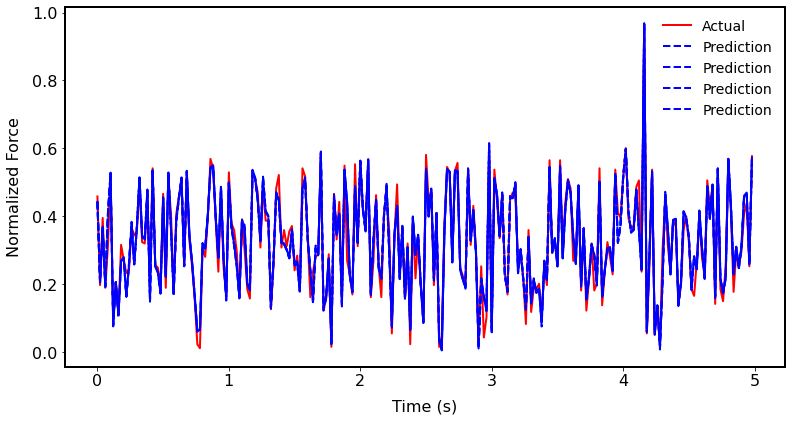

In [ ]:
import matplotlib as mpl
from pylab import cm

#mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

colors = cm.get_cmap('rainbow', 2)

fig = plt.figure(figsize = [10,5])
ax = fig.add_axes([0, 0, 1, 1])

#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)

time = np.arange(0, 5, 5/250)
ax.plot(time, test_label[0:1000:4], label='Actual', linewidth=2, c='r', linestyle='-')
ax.plot(time, prediction_1[0:1000:4], label='Prediction', linewidth=2, c='b', linestyle='--')

plt.legend(frameon=False)
ax.set_xlabel('Time (s)', labelpad=10)
ax.set_ylabel('Normalized Force', labelpad=10)
#ax.set_title("LSTM Network")

ax.legend(bbox_to_anchor=(1, 1), loc=0, frameon=False, fontsize=14)

plt.savefig('prediction.png', dpi = 900, bbox_inches='tight')

In [ ]:
model_1.save("PFmlp.h5")